In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.35
set_session(tf.Session(config=config))

/home/dada/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")


import string
characters = string.digits + string.ascii_uppercase + string.whitespace[0]
print(characters)

width, height, n_len, n_class = 200, 60, 6, len(characters)+1

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ 


# Model

In [3]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Conv2D(filters=32*(2**i), kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=32*(2**i), kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

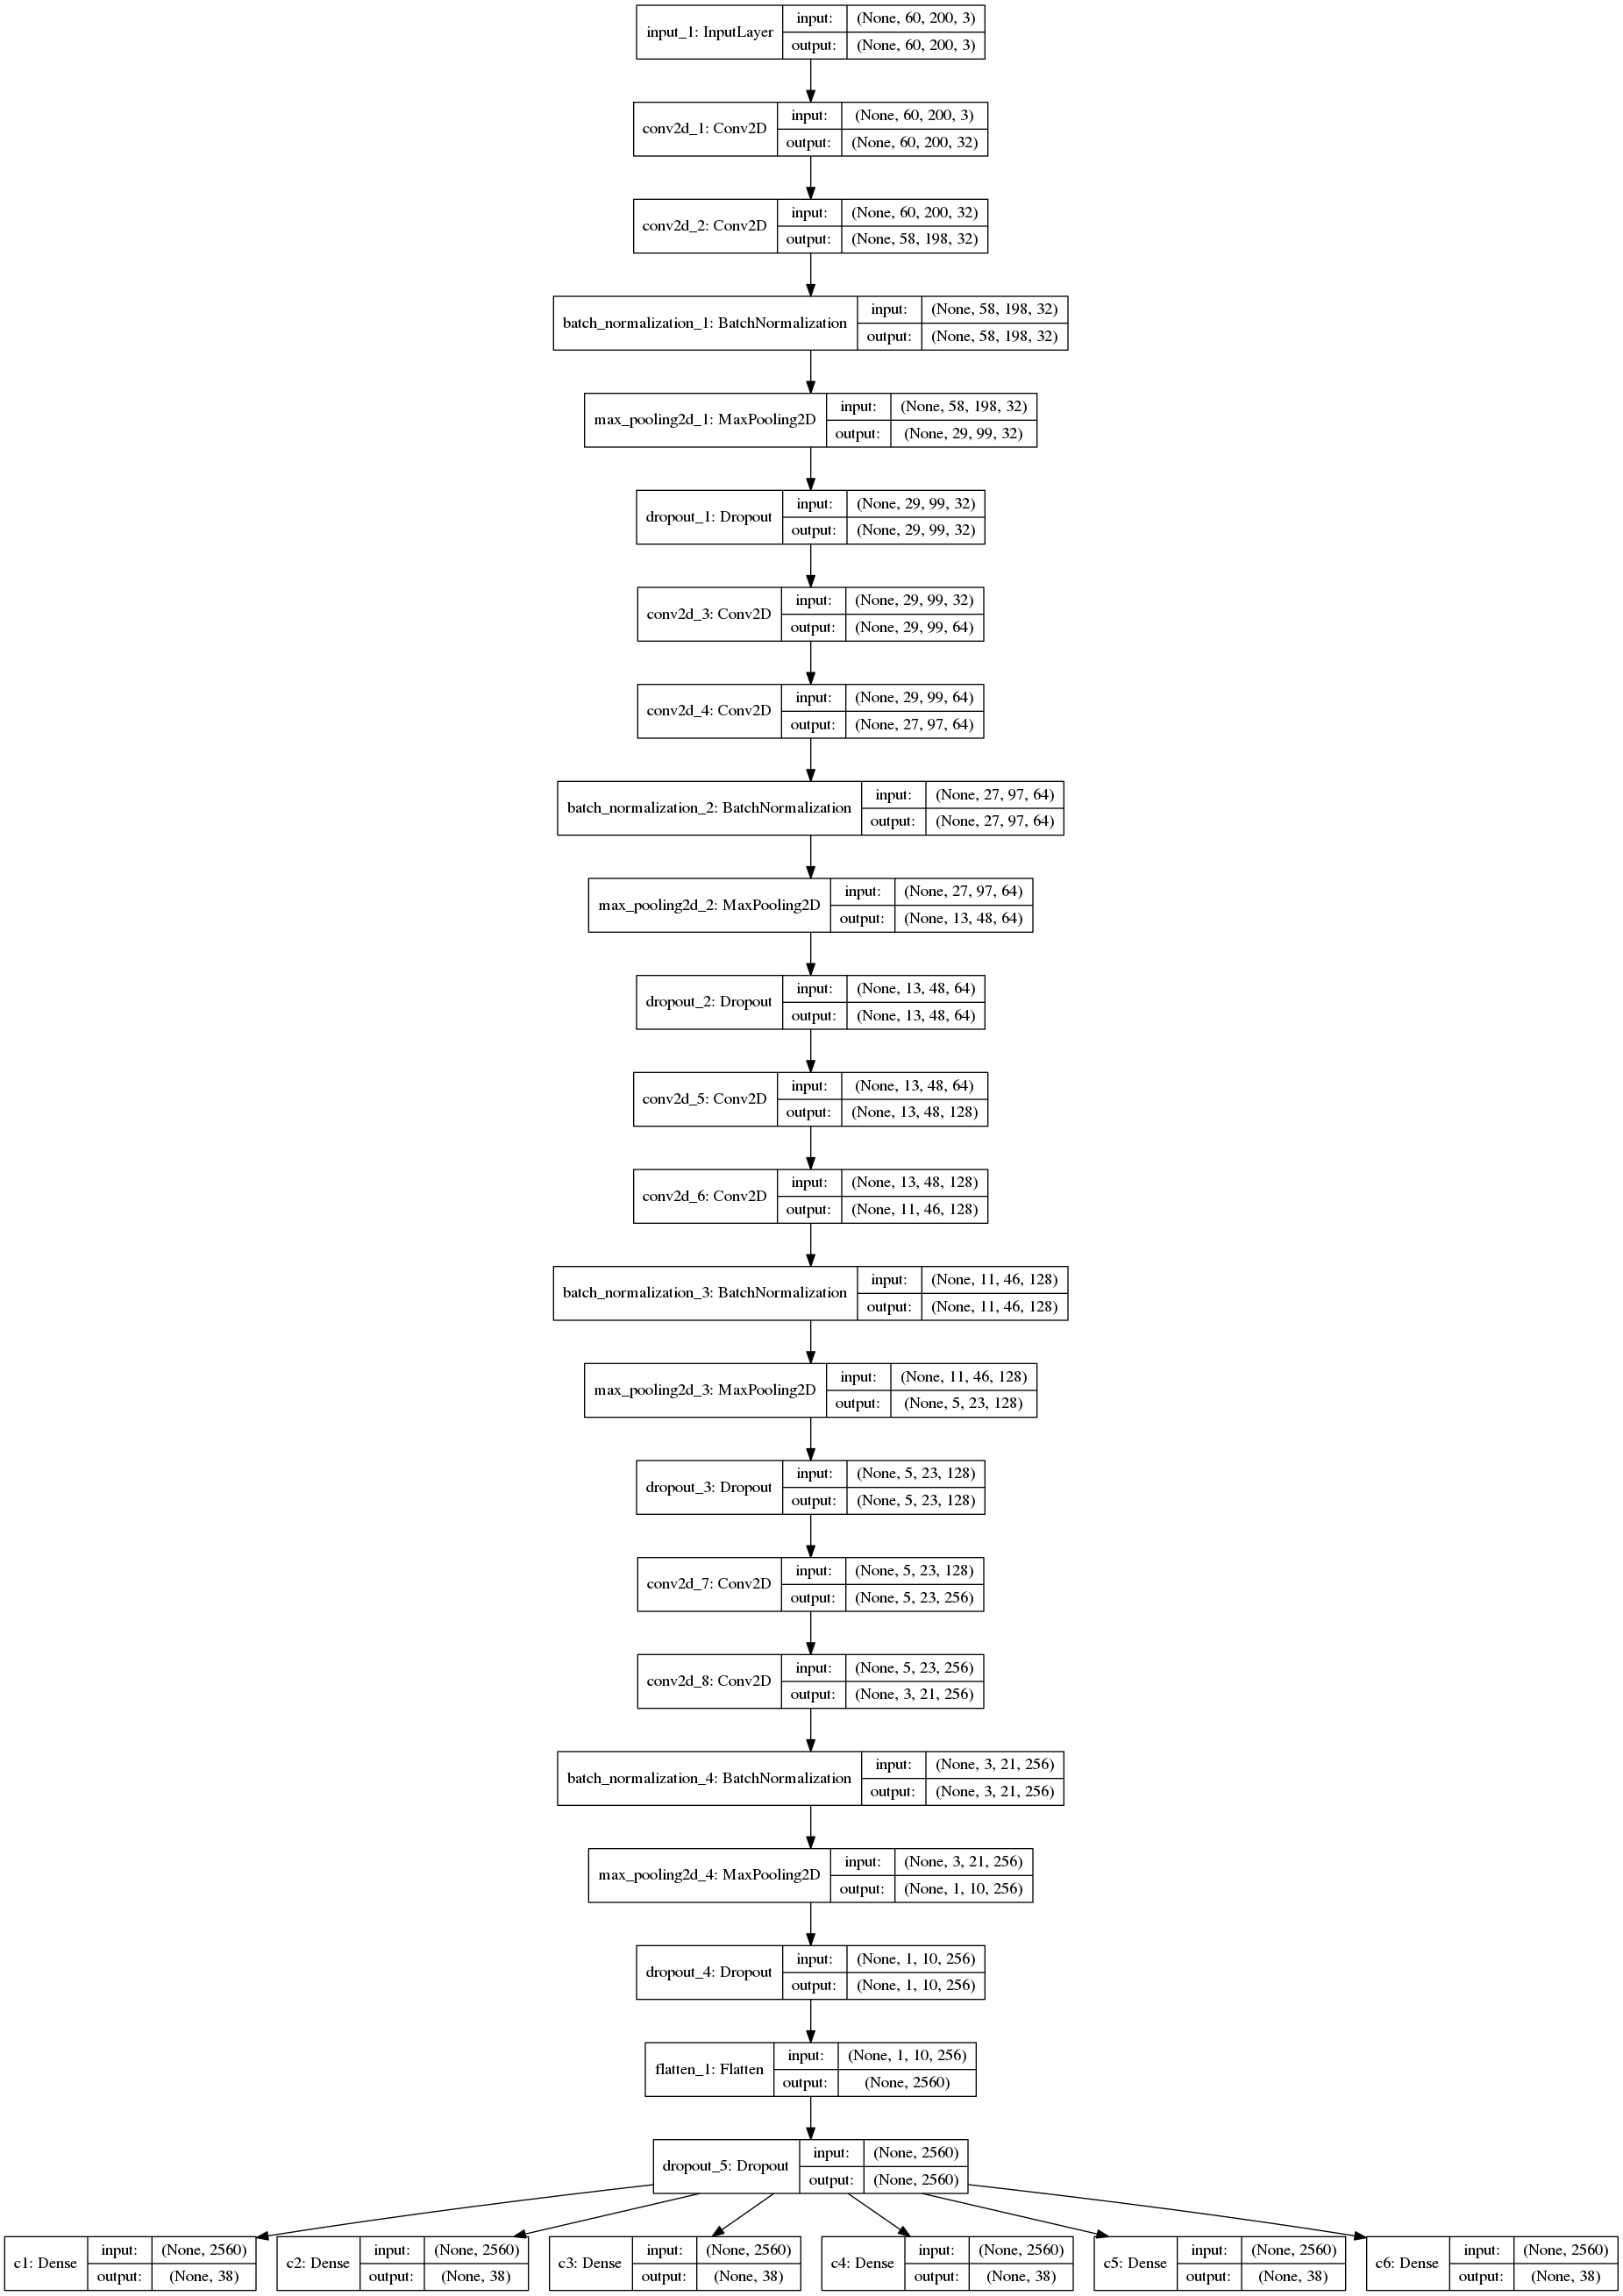

In [4]:
from IPython.display import Image
from keras.utils import plot_model

plot_model(model, to_file='models/model_6.png', show_shapes=True)
Image('models/model_6.png')

# Read data

In [5]:
import pandas as pd
labels = pd.read_csv('data/captcha/label.csv', header=None)
labels.head(10)

,0,1
0,1,RJRK1
1,2,67390A
2,3,XKEQVA
3,4,TJ9Z8V
4,5,GQMQYE
5,6,EVYJY0
6,7,7B8VX
7,8,LUYDZ
8,9,FTV5K
9,10,U8RAD1


In [6]:
# drop labels with length 5
drop = []
for e, i in enumerate(labels[1]):
    if len(i) != n_len:
        drop.append(e)
print ('drop', len(drop))

labels = labels.drop(drop)
print ('left', len(labels))
labels.head(10)

drop 65580
left 65492


,0,1
1,2,67390A
2,3,XKEQVA
3,4,TJ9Z8V
4,5,GQMQYE
5,6,EVYJY0
9,10,U8RAD1
10,11,26DYXA
12,13,ESXUKW
18,19,8ZHG5R
20,21,QX2948


In [7]:
all_imgs = [plt.imread('data/captcha/'+str(i)+'.jpg') for i in labels[0]]
print (len(all_imgs), len(labels))

65492 65492


# Data generator

In [8]:
from keras.utils import to_categorical
def gen(batch_size=128):
    while True:
        batch_idx = np.random.randint(50000, size=batch_size)
        X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
        y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
        for i, idx in enumerate(batch_idx):
            img = all_imgs[idx]
            label = labels[1].values[idx]
            X[i] = img
            for j in range(n_len):
                y[j][i] = to_categorical(characters.find(label[j]), n_class)
              
        yield X, y

In [9]:
def gen_val(batch_size=128):
    while True:
        batch_idx = np.random.randint(15449, size=batch_size)
        X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
        y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
        for i, idx in enumerate(batch_idx):
            idx += 50000
            img = all_imgs[idx]
            label = labels[1].values[idx]
            X[i] = img
            for j in range(n_len):
                y[j][i] = to_categorical(characters.find(label[j]), n_class)
            
        yield X, y

# Decoder

Text(0.5,1,'1ECVAQ')

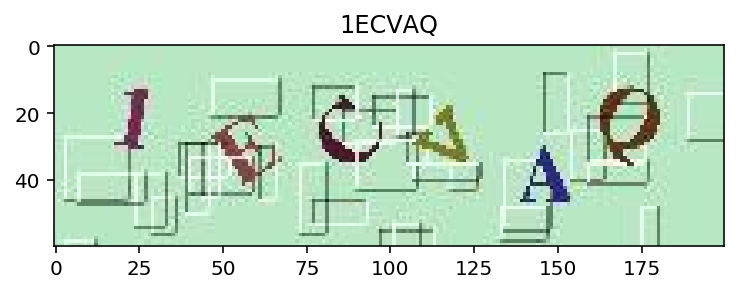

In [10]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

# Training

In [11]:
def evaluate(model, batch_num=20):
    batch_acc1 = 0
    batch_acc2 = 0
    generator = gen_val()
    for i in range(batch_num):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        batch_acc1 += np.mean((y_true == y_pred))
        batch_acc2 += np.mean((y_true == y_pred).sum(1) == n_len)
    
    print ('acc')
    print ('char:', batch_acc1 / batch_num)
    print ('word:', batch_acc2 / batch_num )
    return batch_acc1 / batch_num

In [12]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(model)*100
        self.accs.append(acc)
        

evaluator = Evaluate()
mcp = ModelCheckpoint('models/model_cnn_6.h5', 
                          monitor="val_acc", 
                          save_best_only=True, 
                          save_weights_only=False)

In [13]:
K.tensorflow_backend._get_available_gpus()
history = model.fit_generator(gen(128), steps_per_epoch=int(51200/128), nb_epoch=20,
                    callbacks=[EarlyStopping(patience=3), evaluator, mcp],
                    validation_data=gen_val(128), validation_steps=10)

Epoch 1/20
800/800 [==============================] - 119s 148ms/step - loss: 13.7892 - c1_loss: 2.2669 - c2_loss: 2.2127 - c3_loss: 2.2235 - c4_loss: 2.2144 - c5_loss: 2.2628 - c6_loss: 2.6088 - c1_acc: 0.3424 - c2_acc: 0.3558 - c3_acc: 0.3541 - c4_acc: 0.3546 - c5_acc: 0.3407 - c6_acc: 0.2542 - val_loss: 1.7438 - val_c1_loss: 0.2295 - val_c2_loss: 0.2854 - val_c3_loss: 0.2792 - val_c4_loss: 0.2764 - val_c5_loss: 0.3337 - val_c6_loss: 0.3396 - val_c1_acc: 0.9500 - val_c2_acc: 0.9242 - val_c3_acc: 0.9359 - val_c4_acc: 0.9227 - val_c5_acc: 0.9125 - val_c6_acc: 0.9313
acc
char: 0.9252604166666668
word: 0.651171875
Epoch 2/20
800/800 [==============================] - 152s 189ms/step - loss: 0.7894 - c1_loss: 0.1213 - c2_loss: 0.1039 - c3_loss: 0.0995 - c4_loss: 0.1026 - c5_loss: 0.1232 - c6_loss: 0.2389 - c1_acc: 0.9692 - c2_acc: 0.9732 - c3_acc: 0.9738 - c4_acc: 0.9720 - c5_acc: 0.9664 - c6_acc: 0.9287 - val_loss: 0.1040 - val_c1_loss: 0.0355 - val_c2_loss: 0.0062 - val_c3_loss: 0.0188 

# Testing

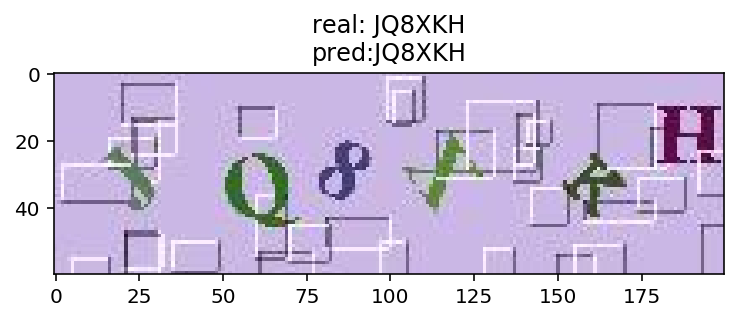

In [14]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0])
plt.show()

In [15]:
evaluate(model)

acc
char: 0.9979166666666666
word: 0.987890625


0.9979166666666666

In [16]:
#model.save('models/model_cnn_6.h5')